## Import bibliotek i danych

In [1]:
# Biblioteki do manipulacji zbiorem
import pandas as pd
import numpy as np

# Biblioteki do wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# Biblioteka do standaryzacji danych
from sklearn.preprocessing import StandardScaler

# Biblioteki do klasyfikacji
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Biblioteki do k najbliższych sąsiadów
from sklearn.neighbors import KNeighborsClassifier

# Biblioteki do analizy wyników
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# Biblioteki do Sparka 
from pyspark import SparkContext, SparkConf

In [2]:
# conf = SparkConf().setAppName('Klasyfikacja').setMaster('spark://25.62.116.201:7077')
# sc = SparkContext(conf = conf)

In [3]:
diabetes_data = pd.read_csv('diabetes.csv')

## Zastąpienie braków, standaryzacja danych

In [4]:
diabetes_data_fix = diabetes_data.copy(deep = True)
diabetes_data_fix[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data_fix[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
diabetes_data_fix

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6    148.0           72.0           35.0      NaN  33.6   
1              1     85.0           66.0           29.0      NaN  26.6   
2              8    183.0           64.0            NaN      NaN  23.3   
3              1     89.0           66.0           23.0     94.0  28.1   
4              0    137.0           40.0           35.0    168.0  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10    101.0           76.0           48.0    180.0  32.9   
764            2    122.0           70.0           27.0      NaN  36.8   
765            5    121.0           72.0           23.0    112.0  26.2   
766            1    126.0           60.0            NaN      NaN  30.1   
767            1     93.0           70.0           31.0      NaN  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                       0.351   31        0  
2                       0.672   32        1  
3                       0.167   21        0  
4                       2.288   33        1  
..                        ...  ...      ...  
763                     0.171   63        0  
764                     0.340   27        0  
765                     0.245   30        0  
766                     0.349   47        1  
767                     0.315   23        0  

[768 rows x 9 columns]

In [5]:
dd = diabetes_data_fix.copy()
dd['Glucose'].fillna(dd['Glucose'].mean(), inplace = True)
dd['BloodPressure'].fillna(dd['BloodPressure'].mean(), inplace = True)
dd['SkinThickness'].fillna(dd['SkinThickness'].median(), inplace = True)
dd['Insulin'].fillna(dd['Insulin'].median(), inplace = True)
dd['BMI'].fillna(dd['BMI'].mean(), inplace = True)

In [6]:
diabetes_data_X = dd.loc[:, 'Pregnancies':'Age']
diabetes_data_X = StandardScaler().fit_transform(diabetes_data_X)
diabetes_data_y= dd.loc[:, 'Outcome']
diabetes_data_train_X, diabetes_data_test_X, diabetes_data_train_y, diabetes_data_test_y = train_test_split(diabetes_data_X,
                                                               diabetes_data_y,
                                                               random_state=2, train_size=0.7)

## Klasyfikacja
### Lasy losowe

In [7]:
forest = RandomForestClassifier(n_estimators=70, max_leaf_nodes=11, n_jobs=-1, random_state=0)
forest.fit(diabetes_data_train_X, diabetes_data_train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=11, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70, n_jobs=-1,
                       oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [8]:
forest_train_score = forest.score(diabetes_data_train_X, diabetes_data_train_y)
forest_test_score = forest.score(diabetes_data_test_X, diabetes_data_test_y)
print("Dokladnosc klasyfikacji lasu losowego na zbiorze treningowym wynosi {:.1%}, \
zas na zbiorze testowym {:.1%}".format(forest_train_score,
                                       forest_test_score))

Dokladnosc klasyfikacji lasu losowego na zbiorze treningowym wynosi 82.5%, zas na zbiorze testowym 79.2%


Text(0.5, 15.0, 'Predicted label')

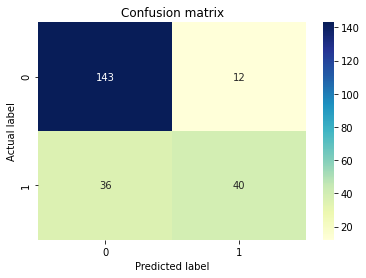

In [9]:
y_pred = forest.predict(diabetes_data_test_X)

cnf_matrix = metrics.confusion_matrix(diabetes_data_test_y, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

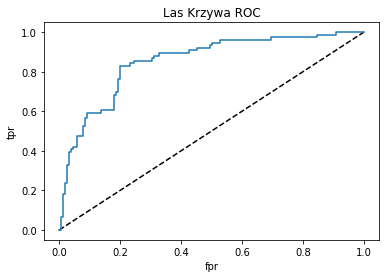

In [10]:
y_pred_proba = forest.predict_proba(diabetes_data_test_X)[:,1]
fpr, tpr, thresholds = roc_curve(diabetes_data_test_y, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Las Krzywa ROC')
plt.show()

In [11]:
print('Skuteczność (na podstawie pola pod krzywą ROC): ' ,"{:.1%}".format(roc_auc_score(diabetes_data_test_y,y_pred_proba)))

Skuteczność (na podstawie pola pod krzywą ROC):  85.2%


# K najbliższych sąsiadów

In [12]:
test_scores = []
train_scores = []

for i in range(1,19):

    knn = KNeighborsClassifier(i)
    knn.fit(diabetes_data_train_X,diabetes_data_train_y)
    
    train_scores.append(knn.score(diabetes_data_train_X,diabetes_data_train_y))
    test_scores.append(knn.score(diabetes_data_test_X,diabetes_data_test_y))

In [20]:
## score that comes from testing on the same datapoints that were used for training
max_train_score = max(train_scores)
train_scores_ind = [i for i, v in enumerate(train_scores) if v == max_train_score]
print('Najlepszy wynik na zbiorze treningowym = {}%,  k = {}'.format(max_train_score*100,list(map(lambda x: x+1, train_scores_ind))))



Najlepszy wynik na zbiorze treningowym = 100.0%,  k = [1]


In [21]:
max_test_score = max(test_scores)
test_scores_ind = [i for i, v in enumerate(test_scores) if v == max_test_score]
print('Najlepszy wynik na zbiorze testowym = {}%,  k = {}'.format(max_test_score*100,list(map(lambda x: x+1, test_scores_ind))))

Najlepszy wynik na zbiorze testowym = 74.89177489177489%,  k = [17]


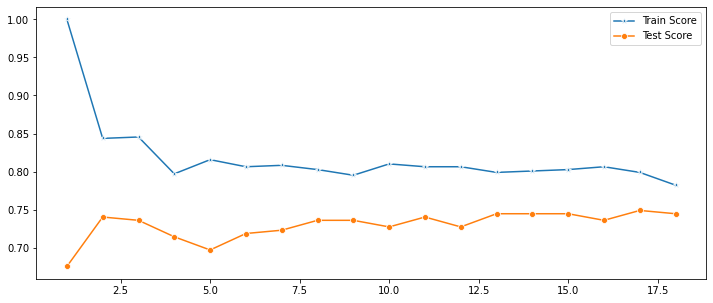

In [15]:
plt.figure(figsize=(12,5))
p = sns.lineplot(range(1,19),train_scores,marker='*',label='Train Score')
p = sns.lineplot(range(1,19),test_scores,marker='o',label='Test Score')

In [16]:
knn = KNeighborsClassifier(11)

# wczytanie danych do knn 
knn.fit(diabetes_data_train_X,diabetes_data_train_y)

# stworzenie oceny na podstawie danych testowych
score = knn.score(diabetes_data_test_X,diabetes_data_test_y)
print('skuteczność:',"{:.0%}".format(score))

skuteczność: 74%


Text(0.5, 15.0, 'Predicted label')

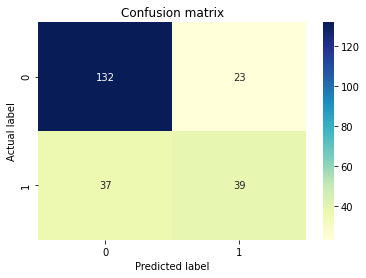

In [17]:
y_pred = knn.predict(diabetes_data_test_X)

cnf_matrix = metrics.confusion_matrix(diabetes_data_test_y, y_pred)
p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

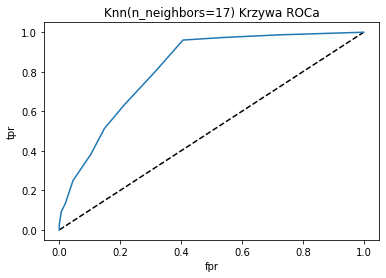

In [18]:
y_pred_proba = knn.predict_proba(diabetes_data_test_X)[:,1]
fpr, tpr, thresholds = roc_curve(diabetes_data_test_y, y_pred_proba)

plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Knn(n_neighbors=17) Krzywa ROCa')
plt.show()

In [19]:
print('Skuteczność (na podstawie pola pod krzywą ROC): ' ,"{:.1%}".format(roc_auc_score(diabetes_data_test_y,y_pred_proba)))

Skuteczność (na podstawie pola pod krzywą ROC):  82.0%


In [ ]:
forest.